<a href="https://colab.research.google.com/github/HariTarz/Men-Women_Gender_classfication_using_ResNet50/blob/main/Men_Women_Gender_classification_using_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Required Packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import resnet50

## Creating dataset from images and splitting them into training and Validation sets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
bat_size = 128
img_size = (160, 160)

# Setting the dataset directory, reading and splitting the dataset as training and validation sets.
directory= "/content/drive/MyDrive/Colab Notebooks/Deep Learning/Men-Women_Gender_classification_using_ResNet50/dataset/"
train_dataset = image_dataset_from_directory(directory, shuffle = True,
                                             batch_size = bat_size,
                                             image_size = img_size,
                                             validation_split = 0.2,
                                             subset= 'training',
                                             seed= 3)
validation_dataset = image_dataset_from_directory(directory, shuffle = True,
                                             batch_size = bat_size,
                                             image_size = img_size,
                                             validation_split = 0.2,
                                             subset= 'validation',
                                             seed= 3)

Found 3338 files belonging to 2 classes.
Using 2671 files for training.
Found 3338 files belonging to 2 classes.
Using 667 files for validation.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


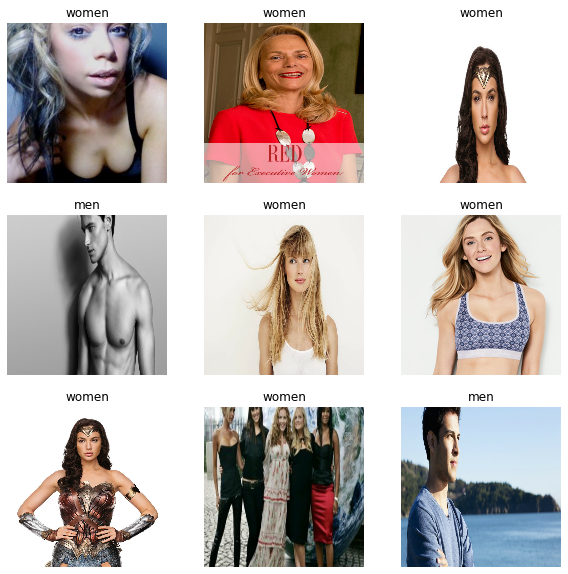

In [ ]:
#Getting the available class names.
class_names = train_dataset.class_names

#Ploting the 10 images in the mini-batch.
plt.figure(figsize = (10,10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

## Preprocessing

### Data prefetching

In [ ]:
#Prefetching data to prevent memory bottleneck while reading from the virtual storage.
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size= AUTOTUNE)

### Data augmentation

In [ ]:
#Creating a function for data augmentation for images
def data_augmenter():
  '''This function will take the images and,
  will return the augmented versions of the images'''
  data_aug = tf.keras.Sequential(name= 'data_augmenter')
  data_aug.add(tfl.RandomFlip('horizontal'))
  data_aug.add(tfl.RandomRotation(0.2))

  return data_aug

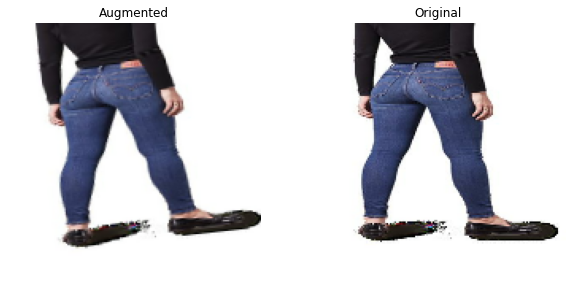

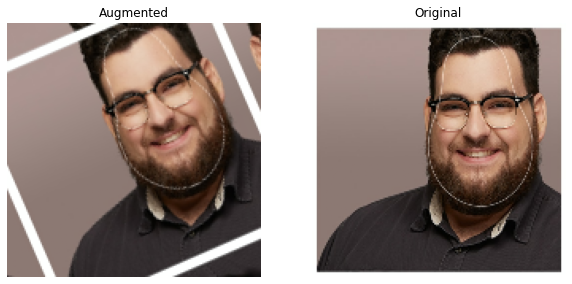

In [ ]:
#Preview of augmented image
data_augmentation = data_augmenter()

for image, labels in train_dataset.take(1):
  plt.figure(figsize=(10,10))
  ax = plt.subplot(1, 2, 1)
  augmented_image = data_augmentation(image[0])
  plt.imshow(augmented_image/255)
  plt.title('Augmented')
  plt.axis('off')
  ax = plt.subplot(1, 2, 2)
  plt.imshow(image[0]/255)
  plt.title('Original')
  plt.axis('off')

## ResNet50 model

In [ ]:
IMG_SHAPE = img_size + (3,)
base_model = resnet50.ResNet50(include_top= False, 
                                 weights= 'imagenet', 
                                 input_shape= IMG_SHAPE)

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 166, 166, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 80, 80, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 80, 80, 64)   256         ['conv1_conv[0][0]']      

In [ ]:
def gender_model(image_shape, data_augmentation=data_augmenter()):
  '''This model for binary classification out of the ResNet50 model
    Arguments:

    Inputs:-
      image_shape -- Image width and height
      data_augmentation -- data augmentation function
    Outputs:-
      Returns -- tf.keras.model'''

  input_shape = image_shape + (3,)

  base_model = resnet50.ResNet50(include_top= False, 
                                 weights= 'imagenet', 
                                 input_shape= input_shape)
  base_model.trainable = False

  inputs = tf.keras.Input(shape= input_shape)

  x = data_augmentation(inputs)

  x = resnet50.preprocess_input(x)

  x = base_model(x, training= False)

  x = tfl.GlobalAveragePooling2D()(x)

  x = tfl.Dropout(0.2)(x)

  x = tfl.Dense(64)(x)
  
  outputs = tfl.Dense(1)(x)

  model = tf.keras.Model(inputs, outputs)

  return model

In [ ]:
model = gender_model(img_size, data_augmenter())

In [ ]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
initial_epochs = 5
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
21/21 [==============================] - 591s 28s/step - loss: 0.8418 - accuracy: 0.7106 - val_loss: 0.4019 - val_accuracy: 0.8681
Epoch 2/5
21/21 [==============================] - 314s 14s/step - loss: 0.4908 - accuracy: 0.8132 - val_loss: 0.3119 - val_accuracy: 0.8786
Epoch 3/5
21/21 [==============================] - 308s 14s/step - loss: 0.4048 - accuracy: 0.8285 - val_loss: 0.3361 - val_accuracy: 0.8516
Epoch 4/5
21/21 [==============================] - 320s 15s/step - loss: 0.3920 - accuracy: 0.8282 - val_loss: 0.3338 - val_accuracy: 0.8531
Epoch 5/5
21/21 [==============================] - 315s 15s/step - loss: 0.3275 - accuracy: 0.8589 - val_loss: 0.3338 - val_accuracy: 0.8591


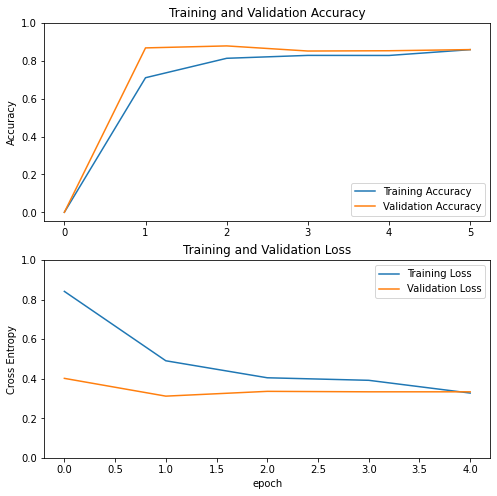

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model = model.layers[4]
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 143

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function= tf.keras.losses.BinaryCrossentropy(from_logits = True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
base_learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(0.1*base_learning_rate)
# Use accuracy as evaluation metric
metrics= ['accuracy']

### END CODE HERE

model.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  175


In [ ]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
21/21 [==============================] - 455s 21s/step - loss: 0.5112 - accuracy: 0.7581 - val_loss: 0.2827 - val_accuracy: 0.8801
Epoch 6/10
21/21 [==============================] - 443s 21s/step - loss: 0.3053 - accuracy: 0.8540 - val_loss: 0.2494 - val_accuracy: 0.8861
Epoch 7/10
21/21 [==============================] - 438s 20s/step - loss: 0.2511 - accuracy: 0.8866 - val_loss: 0.2650 - val_accuracy: 0.8921
Epoch 8/10
21/21 [==============================] - 435s 20s/step - loss: 0.2258 - accuracy: 0.9034 - val_loss: 0.2423 - val_accuracy: 0.8921
Epoch 9/10
21/21 [==============================] - 441s 21s/step - loss: 0.1938 - accuracy: 0.9128 - val_loss: 0.2544 - val_accuracy: 0.8921
Epoch 10/10
21/21 [==============================] - 444s 21s/step - loss: 0.1768 - accuracy: 0.9195 - val_loss: 0.2438 - val_accuracy: 0.9010


In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()